In [1]:
from LibraryENGcopia import *
from tqdm.notebook import tqdm
import sklearn.preprocessing as ps
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from random import randint
from fastdtw import fastdtw
import copy
name_data = '2018-11-27T10-29-42POP 2 BL .h5'
name_data2 = '2018-11-27T12-03-02POP 2 stimulation.h5'
name_data3='2018-11-27T10-56-39MiP5 KA stimulation.h5'
complete_string='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data
complete_string2='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data2
complete_string3='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data3

In [2]:
#data = h5py.File(complete_string,'r')
#data = h5py.File(complete_string2,'r')
data = h5py.File(complete_string3,'r')

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings.shape)

(5875000, 60)


In [3]:
inizio=0
#len_data=128000 #192 secondi
len_data=len(readings)
prova_multi=readings.iloc[inizio:len_data, :17]
#prova=prova.drop([b'Ref'],axis=1)
prova=prova_multi[b'46']
ref=readings[b'Ref']
ref=ref[inizio:len_data]
#prova=readings.iloc[:150000, :5]
print(prova.shape,ref.shape)

(5875000,) (5875000,)


In [4]:
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref)
filt_prova=filtfilt(b,a,prova)
f_prova = filt_prova - filt_ref
prova=f_prova
prova.shape
r_prova=prova.reshape(-1, 1)
scaler = StandardScaler()
s_prova = scaler.fit_transform(r_prova)
prova=s_prova
s_prova.shape

(5875000, 1)

In [5]:
pos, neg=find_all_spikes(prova)

100%|████████████████████████████▉| 5874693/5874700 [00:13<00:00, 439790.11it/s]

detected spikes: 63671 firing rate:  108.37617021276596


firing rate baseline: 90
firing rate pop 2 stimulation: 87
firing rate pop 5 KA stimulation: 110

In [6]:
len(pos)

22257

In [7]:
pos_cut,n_pos, neg_cut,n_neg = cut(pos,neg,prova)
savedp = copy.deepcopy(pos_cut)
savedn = copy.deepcopy(neg_cut)

0 3583 3583 0 6602 6602


In [8]:
pos_cut=mask_cuts(pos_cut)
neg_cut= mask_cuts(neg_cut)

(3583, 30)
(6602, 30)


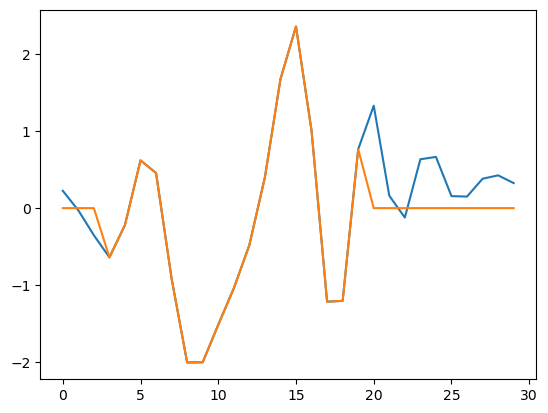

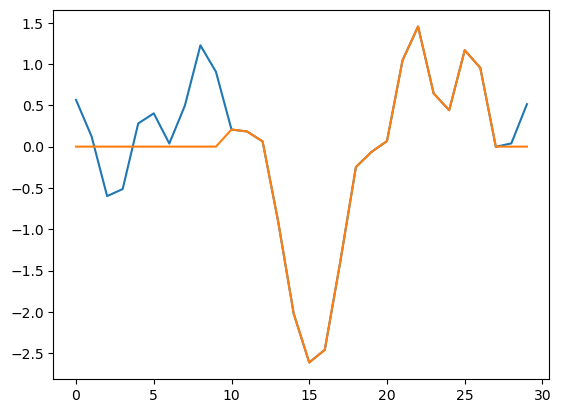

In [9]:
x=randint(1,min(len(pos_cut),len(neg_cut)))

plt.plot(savedp[x])
plt.plot(pos_cut[x])
plt.show()
plt.plot(savedn[x])
plt.plot(neg_cut[x])
plt.show()

Total spikes:  3583
transformed
For 2 clusters, the silhouette score is: 0.21301315859241327


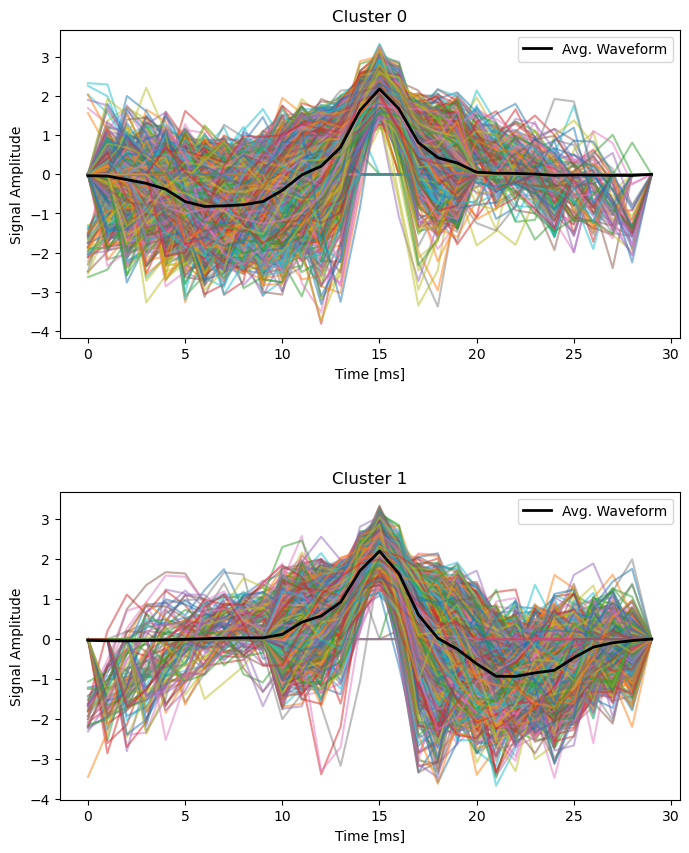

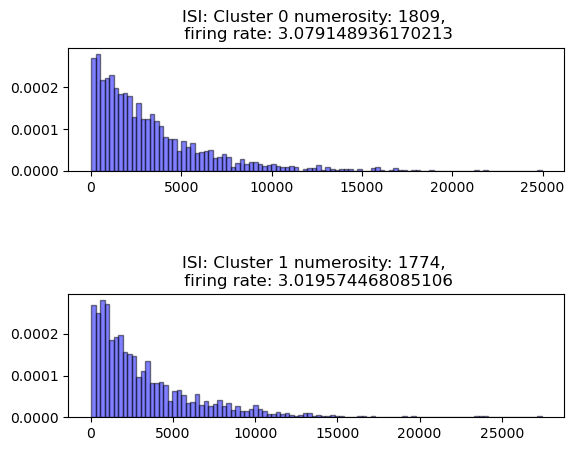

In [10]:
final_data_pos= clus(pos_cut,'PCA','fuzzy',n_pos,2,len_data)

baseline: 2 cluster (10, 9 firing rates)
pop 2 stimulation: 2 cluster (19, 17 firing rates)

Total spikes:  6602
transformed
For 2 clusters, the silhouette score is: 0.2064686030500535


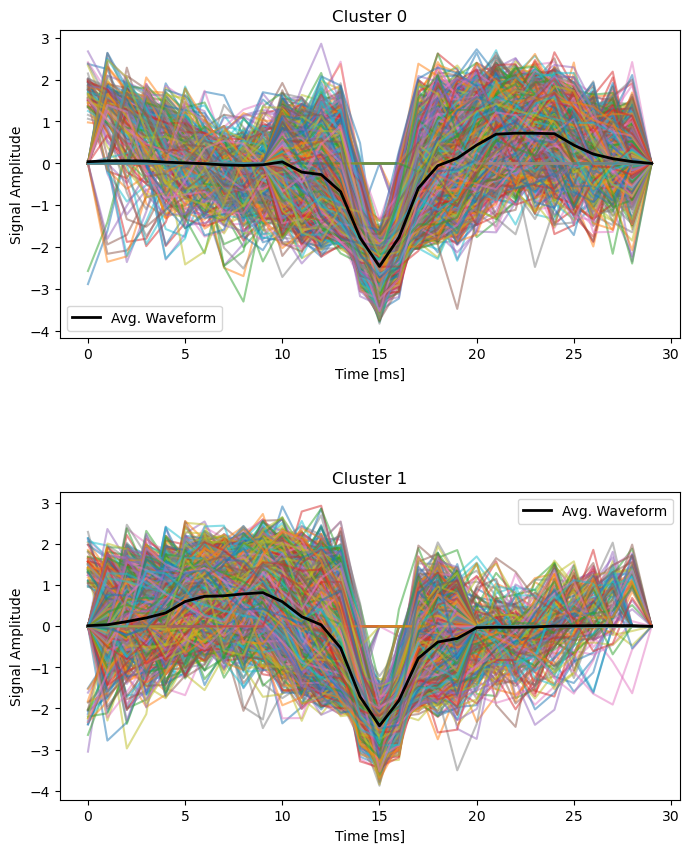

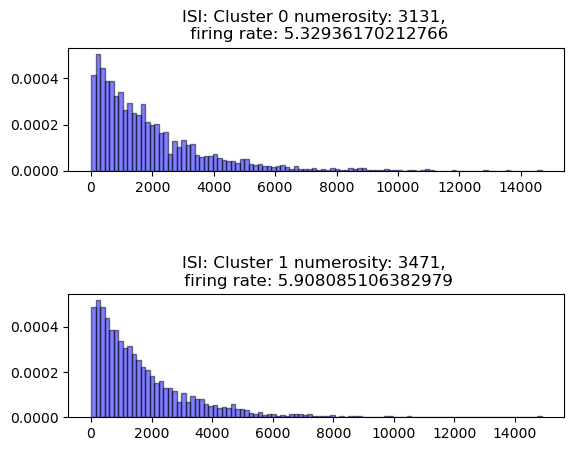

In [12]:
final_data_neg= clus(neg_cut,'PCA','fuzzy',n_neg,2,len_data)

In [13]:
neurons = []
#for electrode in cluster:
for neuron in final_data_pos:
    neurons.append(neuron)
for neuron in final_data_neg:
    neurons.append(neuron)
neurons

[array([   4261,    4429,    8944, ..., 5864584, 5865031, 5866062]),
 array([   4150,    8559,    9495, ..., 5863117, 5863472, 5869207]),
 array([    876,    4213,    6658, ..., 5867216, 5872554, 5873099]),
 array([    840,    1092,    1825, ..., 5871955, 5872336, 5873586])]

In [14]:
data_healthy=neurons[2]
ISI_healthy = np.diff(data_healthy)/10000

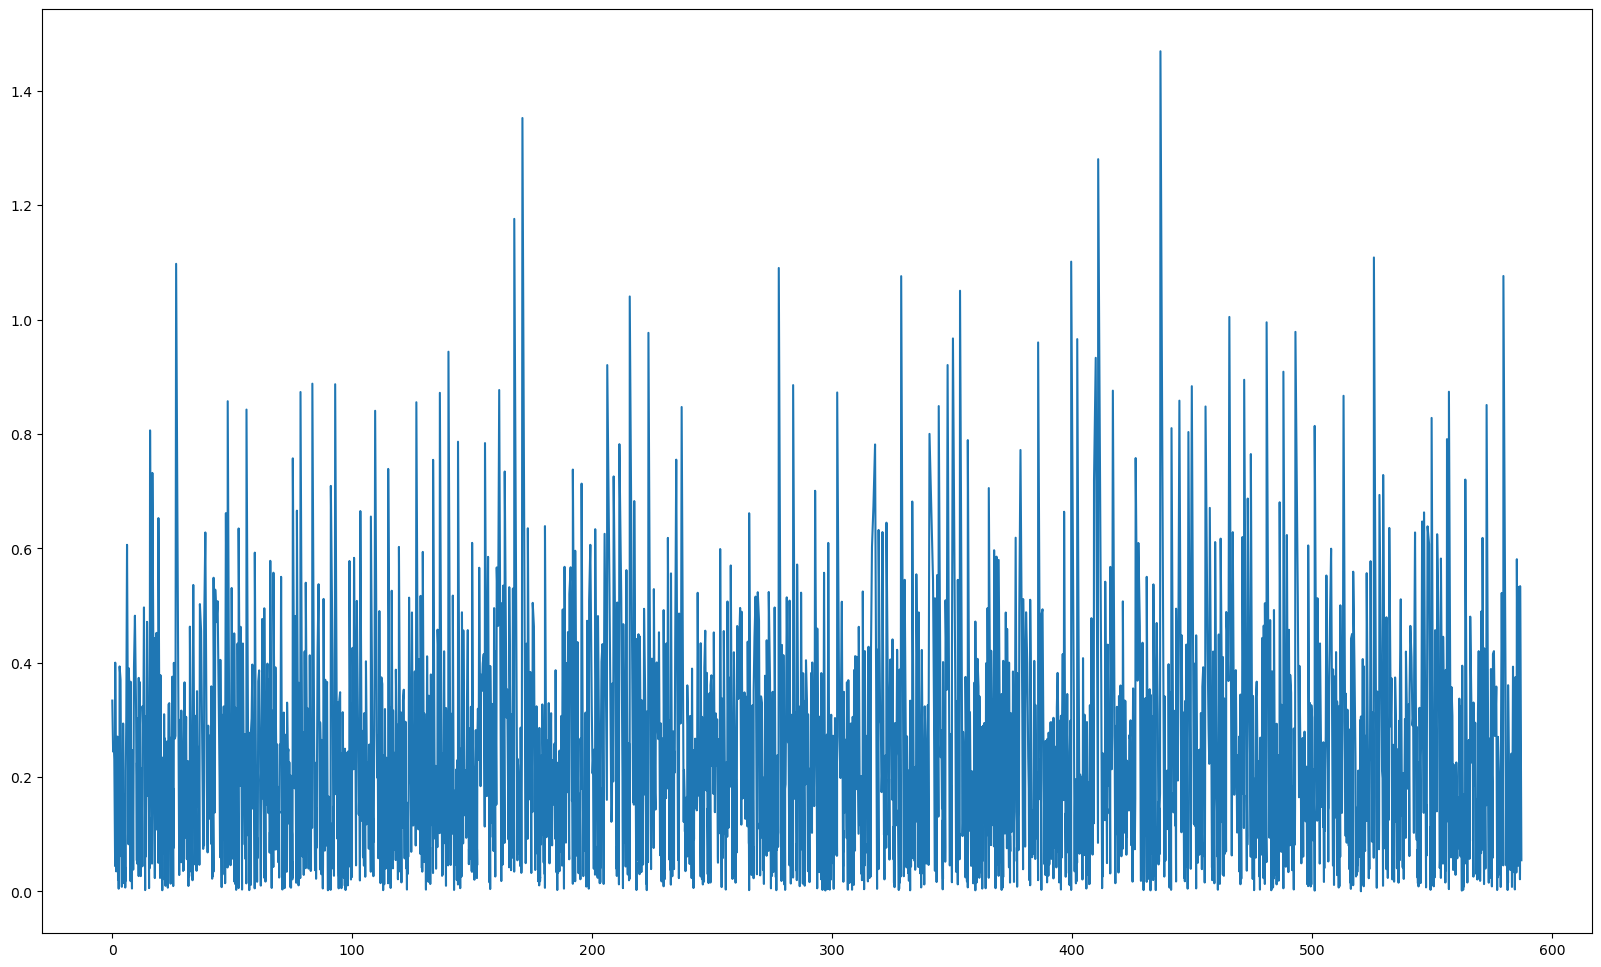

In [23]:
plt.figure(figsize=(20,12))
plt.plot(data_healthy[:-1]/10000,ISI_healthy)

In [25]:
min(ISI_healthy)

0.0002

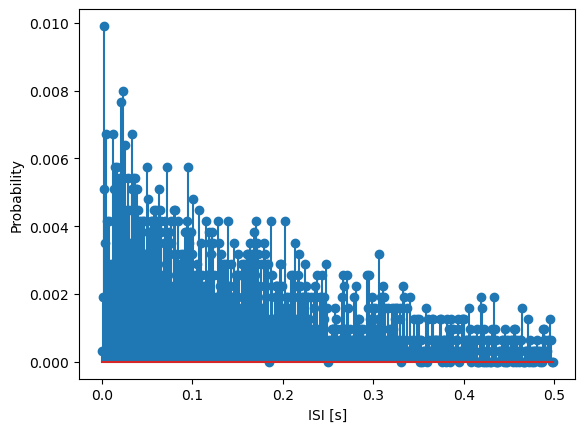

In [26]:
bins = np.arange(0, .5, 0.001)           # Define 1 ms bins for histogram,
counts, _ = np.histogram(ISI_healthy, bins)  # ... compute histogram of the ISIs,
prob = counts / len(ISI_healthy)             # ... convert to probability,
plt.figure()                 # ... create figure and axes objects that we can reuse later,
plt.stem(bins[:-1], prob)                 # ... and plot the probabilities,                # ... with fixed x-limits,
plt.xlabel('ISI [s]')                        # ... and axes labeled.
plt.ylabel('Probability')
plt.show()

In [29]:
import pymc as pm

In [52]:
with pm.Model() as model:
    mu1 = pm.Uniform('mu1',lower=0.01,upper=0.1)
    lam1 = pm.Uniform('lam1',lower=0.01,upper=0.04)
    obs1 = pm.Wald('obs1',mu=mu1,lam=lam1,observed=ISI_healthy)

    '''
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    mu1 = pm.Uniform('mu1',lower=0.01,upper=0.1)
    lam1 = pm.Uniform('lam1',lower=0.01,upper=0.04)
    obs1 = pm.Wald('like',mu=mu1,lam=lam1,observed=ISI_healthy)
    '''
    
    step = pm.NUTS(target_accept=0.9)
    trace = pm.sample(step=step,draws=1000,tune=1000,cores=12)

Multiprocess sampling (12 chains in 12 jobs)
NUTS: [mu1, lam1]


Sampling 12 chains for 1_000 tune and 1_000 draw iterations (12_000 + 12_000 draws total) took 115 seconds.


In [53]:
map_estimate = pm.find_MAP(model=model)

map_estimate

{'mu1_interval__': array(18.96842807),
 'lam1_interval__': array(16.6014022),
 'mu1': array(0.1),
 'lam1': array(0.04)}

ig_waic = pm.waic(trace, model)

ig_waic

Sampling: [obs1]


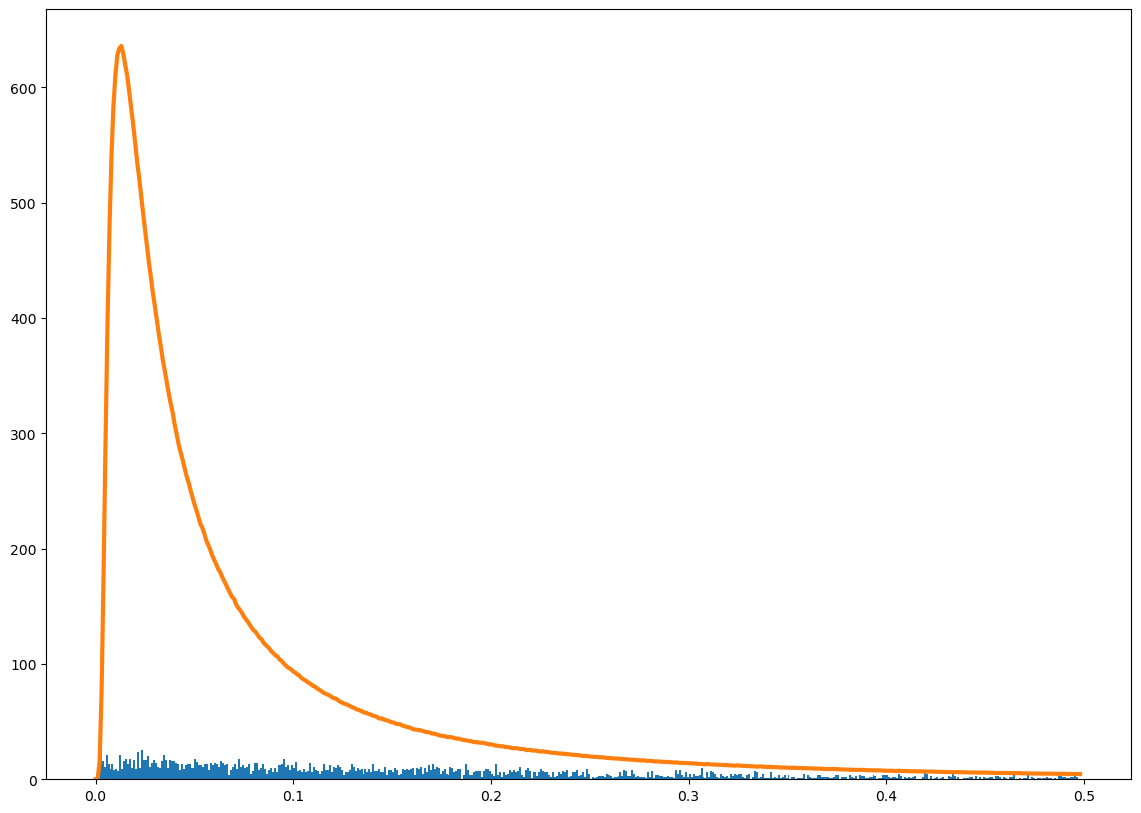

In [56]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace,model=model)

bins = np.arange(0, .5, 1e-3) 
plt.figure (figsize=(14,10))

hist = np.histogram(ppc_trace['posterior_predictive']['obs1'].values,bins=bins)
#plt.axis([0,0.3,0,160])
a= plt.hist(ISI_healthy,bins)
plt.plot(hist[1][:-1],hist[0]/1000,linewidth=3);

In [73]:
lista_samples=[]
for i in list(ppc_trace['posterior_predictive']['like'].values):
    lista_samples.extend(i)

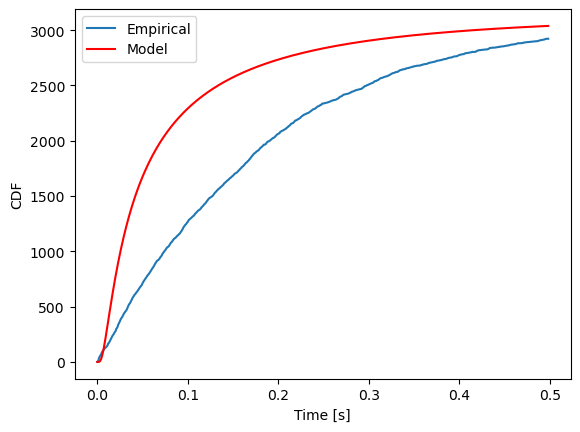

In [94]:
counts, _ = np.histogram(ISI_healthy, bins) 
prob_emp = counts #/ (len(ISI_healthy))
counts, _ = np.histogram(lista_samples, bins) 
prob_model = counts / (len(lista_samples))

Femp = np.cumsum(prob_emp)           
Fmodel = np.cumsum(prob_model)          
plt.figure()
plt.plot(bins[:-1], Femp)                
plt.plot(bins[:-1], Fmodel, 'r')       
#plt.xlim([0, 0.2])                  
plt.xlabel('Time [s]')
plt.ylabel('CDF')
plt.legend(['Empirical','Model'])
plt.show()

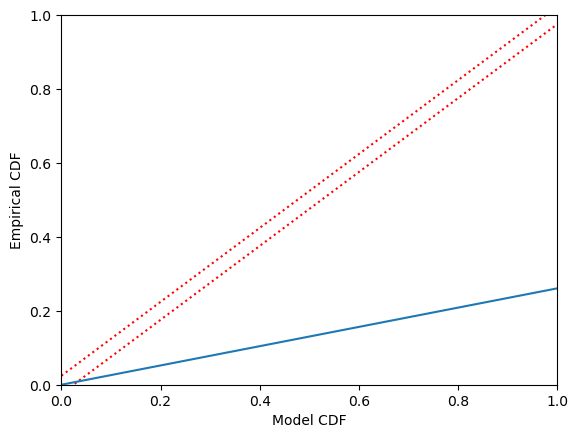

In [99]:
prob_emp = counts / (len(ISI_healthy))
Femp = np.cumsum(prob_emp)           

plt.figure()
Nlow = len(ISI_healthy)  
# Plot the confidence bounds
plt.plot([0, 1], [x + 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot([0, 1], [x - 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot(Femp, Fmodel)    
plt.axis([0, 1, 0, 1])         
plt.xlabel('Model CDF')
plt.ylabel('Empirical CDF')
plt.show()

In [44]:
ISI_data=ISI_healthy
with pm.Model() as model:
    ##### WALD DISTRIBUTION (INVERSE GAUSSIAN)
    #BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    mu1 = pm.Uniform('mu1',lower=0.01,upper=0.1)
    lam1 = pm.Uniform('lam1',lower=0.01,upper=0.04)
    obs1 = pm.Wald.dist(mu=mu1,lam=lam1)

    ###### NORMAL DISTRIBUTION 
    mu2 = pm.Uniform('mu2',lower=0,upper=0.2)
    sigma = pm.Uniform('sigma',lower=0.0001,upper=0.5)
    #obs2 = pm.Bound(pm.Normal, lower=0.0).dist(mu=mu2,sigma=sigma)
    normal_dist = pm.Normal.dist(mu=mu2, sigma=sigma)
    obs2 = pm.Truncated("obs2", normal_dist, lower=0.0)
    #obs2 = pm.TruncatedNormal('obs2', mu=mu2, sigma=sigma, lower=0.0)

    mu3 = pm.Uniform('mu3',lower=0.1,upper=0.6)
    sigma3 = pm.Uniform('sigma3',lower=0.0001,upper=0.5)
    #obs3 = pm.Bound(pm.Normal, lower=0.0).dist(mu=mu3,sigma=sigma3)
    #obs3 = pm.TruncatedNormal('obs3', mu=mu3, sigma=sigma3, lower=0.0)
    normal_dist = pm.Normal.dist(mu=mu3, sigma=sigma3)
    obs3 = pm.Truncated("obs3", normal_dist, lower=0.0)
    
    w = pm.Dirichlet('w', a=np.array([1., .4, .4]))
    like = pm.Mixture('like', w=w, comp_dists = [obs1, obs2, obs3], observed=ISI_data)
    map_estimate = pm.find_MAP(model=model)


ValueError: The dist obs2 was already registered in the current model.
You should use an unregistered (unnamed) distribution created via the `.dist()` API instead, such as:
`dist=pm.Normal.dist(0, 1)`

In [ ]:
model

In [46]:
map_estimate = pm.find_MAP(model=model)

KeyboardInterrupt: 

In [23]:
#def Bayesian_mixture_model(ISI_data):
    
        #step = pm.Metropolis(target_accept=0.9)
        #trace = pm.sample(step=step,draws=500,tune=100,progressbar=False,random_seed=10,cores=6)

        
        del map_estimate['w_stickbreaking__']
        del map_estimate['mu1_interval__']
        del map_estimate['lam1_interval__']
        del map_estimate['mu2_interval__']
        del map_estimate['sigma_interval__']
        del map_estimate['mu3_interval__']
        del map_estimate['sigma3_interval__']

        map_estimate['w1'] = map_estimate['w'][0]
        map_estimate['w2'] = map_estimate['w'][1]
        map_estimate['w3'] = map_estimate['w'][2]

        del map_estimate['w']

        map_estimate['n_spikes'] = ISI_data.shape[0]


        #with model:
        #    ppc_trace = pm.sample_posterior_predictive(trace, 50,model=model,progressbar=False,random_seed=10)

        #lista_samples=[]
        #for i in list(ppc_trace['like']):
        #    lista_samples.extend(i)


        #print('P_value: ',ks_2samp(lista_samples,ISI_data,mode = 'asymp').pvalue)

        return map_estimate

In [24]:
neuron=data_healthy
neuron

array([    876,    4213,    6658, ..., 5867216, 5872554, 5873099])

In [25]:
import pymc as pm
ISI_healthy = np.diff(neuron)/10000


map_estimate = Bayesian_mixture_model(ISI_healthy)


ValueError: The dist obs3 was already registered in the current model.
You should use an unregistered (unnamed) distribution created via the `.dist()` API instead, such as:
`dist=pm.Normal.dist(0, 1)`

In [ ]:
len(onecut)

In [ ]:
#manual clustering based on DTW distance:
together=[]
to_remove=[]
orig=copy.deepcopy(neg_cut)
onecut=neg_cut
left=onecut
#for i in range(len(onecut)):
i=1
while i < len(onecut):
    to_remove.append(i)
    for j in range(i+1,100):#len(onecut)):
        print(i,j)
        spike1=onecut[i]
        spike2=onecut[j]
        distance,path=fastdtw(spike1,spike2)
        if distance<5.5:
            print('y')
            inds=(ind[i]-1,ind[j]-1)
            together.append(inds)
            #print(together)
            to_remove.append(j)
            #print(to_remove)
            i+=1
            k=i
            while k<le000in(onecut):
                print(k)
                pre=k-1
                inds=(ind[pre],ind[k]) 
                if inds in together:
                    i+=1
left=np.delete(left,to_remove)

together

In [ ]:
i=1
print(i)
#for i in range(len(onecut)):
nex=i+1
print(nex)
inds=(ind[i],ind[nex])
print(inds)
if inds in together:
    print(inds, 'in')
    i+=1
print(i)


In [ ]:
together

In [ ]:
type(onecut)

In [ ]:
#let's verify the dtw similarity within the identified clusters:
onecut=neg_cut
ind=n_neg
cluster=final_data_neg[0]

lt=len(cluster) * (len(cluster) - 1) // 2
pbar = tqdm(total = lt)
saved=[]
notsaved=[]
dists=[]
for k in cluster:
    for i in range(len(onecut)):
        if ind[i]==k:
            for j in range(i + 1, len(onecut)):
                if ind[j] in cluster:
                    spike1 = onecut[i]
                    spike2 = onecut[j]
                    pbar.update(1)
                    # Calculate DTW distance and alignment path
                    distance, path = fastdtw(spike1, spike2)
                    #if distance<20:
                    s=(ind[i],ind[j])
                    #saved.append(s)
                    #plt.figure()
                    #plt.plot(spike1)
                    #plt.plot(spike2)
                    #plt.show()
                    if distance>15:
                        #print(f"DTW distance between spike {i} {ind[i]},{k} and spike {j} {ind[j]}: {distance}")
                        notsaved.append(onecut[i])
                    else:
                        saved.append(onecut[i])

# Convert the 'saved' list to a numpy array if needed
notsaved = np.array(notsaved)
saved = np.array(saved)
mean=np.mean(dists)
print(mean)
saved

In [ ]:
plt.plot(notsaved.transpose())

In [ ]:
plt.plot(saved.transpose())

baseline: 2 cluster (8,9 firing rate)
pop 2 stimulation: 2 cluster (24, 26 firing rate)

In [ ]:
plt.hist(np.diff(final_data_neg[2]),bins=100, density=True, alpha=0.5, color='blue', edgecolor='black')

In [ ]:
final_data_neg[2]

from fastdtw import fastdtw
i=14
j=17
spike1=pos_cut[i]
spike2=pos_cut[j]
plt.plot(spike1)
plt.plot(spike2)
distance, path = fastdtw(spike1, spike2)

print(f"DTW distance between spike {i+1} and spike {j+1}: {distance}")
print(f"Alignment path: {path}")

In [ ]:
x=randint(1,len(pos_cut))
print(x)

plt.plot(pos_cut[x])

In [ ]:
onecut=neg_cut
ind=n_neg
cluster=final_data_neg[2]
saved=[]

l=8
k=cluster[l]

i+=1
print(ind[i],k)
if ind[i]==k:
    print('proceed')

    j=i
    
    spike1 = onecut[i]
    spike2 = onecut[j]


In [ ]:
for j in range(i + 1, len(onecut)):
    spike1 = onecut[i]
    spike2 = onecut[j]

    distance, path = fastdtw(spike1, spike2)
    if distance<6:
        s=(ind[i],ind[j])
        saved.append(s)
        print(f"DTW distance between spike {i} {ind[i]},{k} and spike {j} {ind[j]}: {distance}")
        if ind[j] in cluster:
            print(ind[j],' cointained in cluster')
        else:
            plt.figure()
            plt.plot(spike1)
            plt.plot(spike2)
            plt.show()


In [ ]:
#compute dtw for spikes 570 and 688 (not in same cluster)
#688 876
#1092 1095 1593 2304 5503 12507 125012
#1577 1801 2009 3202 4213 5211 8226
# 3070 11117 12665 16296 22891 24702 28775 30217
# 3124 51485 53426 

In [ ]:
for p,m in enumerate(final_data_neg):
    for o,n in enumerate(m):
        if n==570:
            print('ind', o,'value',n, 'cluster', m, 'number',p)

In [ ]:
final_data_neg[4]

In [ ]:
onecut=neg_cut
ind=n_neg
cluster=final_data_neg[4]

lt=len(onecut)*len(onecut)
pbar = tqdm(total = lt)
saved=[]
# Iterate through pairs of spikes and apply DTW
for k in cluster:
    for i in range(len(onecut)):
        if ind[i]==k:
            for j in range(i + 1, len(onecut)):
                spike1 = onecut[i]
                spike2 = onecut[j]
                pbar.update(1)
                # Calculate DTW distance and alignment path
                distance, path = fastdtw(spike1, spike2)
                if distance<20:
                    s=(ind[i],ind[j])
                    saved.append(s)
                    plt.figure()
                    plt.plot(spike1)
                    plt.plot(spike2)
                    plt.show()
                    print(f"DTW distance between spike {i} {ind[i]},{k} and spike {j} {ind[j]}: {distance}")
                    print(f"Alignment path: {path}")
saved

In [ ]:
final_data_pos[0]

In [ ]:
final_data_pos[1]

In [ ]:
plt.plot(pos_cut[0])

In [ ]:
final_data_pos[0]

In [ ]:
lt=len(final_data_pos[0])*len(final_data_pos[0])
pbar = tqdm(total = lt)
# Iterate through pairs of spikes and apply DTW
for i in final_data_pos[0]:
    for j in final_data_pos[0]:
        spike1 = pos_cut[i]
        spike2 = pos_cut[j]
        pbar.update(1)
        # Calculate DTW distance and alignment path
        distance, path = fastdtw(spike1, spike2)
        if distance<20:
            plt.figure()
            plt.plot(spike1)
            plt.plot(spike2)
            plt.show()
            print(f"DTW distance between spike {i+1} and spike {j+1}: {distance}")
            print(f"Alignment path: {path}")